##### Problem Formulation

Input: time series data from a lahge retailer where each point is associated with a specific sales volume

Output: prediction for unit sales volume 2 months (60 days) from now

Required data mining function: determine patterns in fluctuating time data such as trend, seasonality, and stationary variance

Potential challenges: noisy data that leads to ambiguous predictions, bias + overfitting as usual

Impakt: more $$ in revenue for company, convert tough customers into happy ones

Ideal solution: highly accurate projection from small dataset with minimal train/test time

In [2]:
#regular schmegular importation

import numpy as np
from datetime import datetime
import pandas as pd

def rmsle(y_hat, y):
    """Compute Root Mean Squared Logarithmic Error"""
    metric = np.sqrt(sum((np.array(list(map(lambda x : np.log(x + 1), y_hat)))
                         - np.array(list(map(lambda x : np.log(x + 1), y))))**2)/len(y))

    return round(metric, 4)

from pandas import read_csv
#from pandas import datetime
from matplotlib import pyplot
# load data (monthly sales)

# use datetime (the Month column) as index
df = read_csv('train.csv', header=0)
df.head()

#change to unambiguous formatting
format = "%Y-%m-%d" 
df['ds']=df.ds.apply(lambda x: datetime.strptime(x, format).date())
df['ds']=pd.to_datetime(df['ds'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1624 entries, 0 to 1623
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1624 non-null   int64         
 1   ds          1624 non-null   datetime64[ns]
 2   y           1624 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 38.2 KB


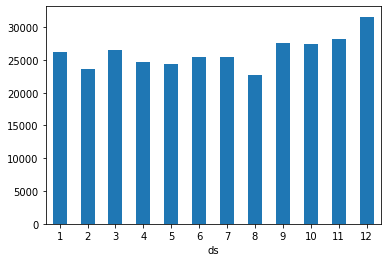

In [3]:
# plot the time series (monthly sale, the data was in month any way)
df.groupby(df["ds"].dt.month)["y"].mean().plot(
    kind='bar', rot=0, 
)
pyplot.show()

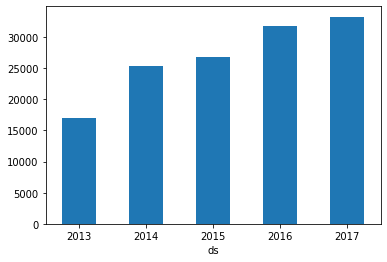

In [4]:
# plot the time series (yearly average sale)
df.groupby(df["ds"].dt.year)["y"].mean().plot(
    kind='bar', rot=0, 
)
pyplot.show()

In [5]:
# any other way to zoom in/zoom out on the time scale by resample?
# But we have to set Month (the datetime) column as index.
df_3m = df.set_index('ds')
# aggregation based on 3 months
df_3m.resample('3M').mean().head()

# aggregation based on 2 years
df_3m.resample('2Y').mean().head()

,Unnamed: 0,y
ds,,
2013-12-31,181.5,16918.625683
2015-12-31,727.5,26014.575994
2017-12-31,1357.5,32300.721030


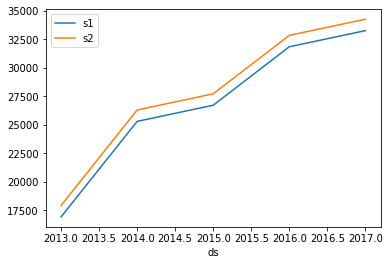

In [6]:
# Comparing multiple time series
import matplotlib.pyplot as plt
s1 = df.groupby(df["ds"].dt.year)["y"].mean()
s2 = df.groupby(df["ds"].dt.year)["y"].mean() + 1000
s1.plot()
s2.plot()
plt.legend(['s1','s2'])
plt.show()

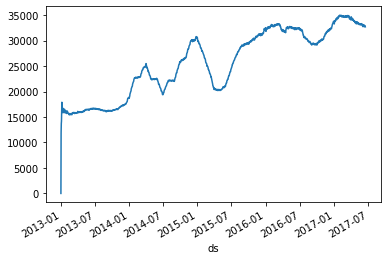

In [7]:
# Rolling 90D average
rolling_df = df.set_index('ds')
rolling_df.y.rolling('90D').mean().plot()
plt.show()

In [8]:
df['y']

0           0.000000
1       23720.568982
2       17329.638000
3       15771.261981
4       22380.072040
            ...     
1619    27224.354996
1620    24254.835000
1621    30156.122999
1622    23314.491985
1623    30598.837000
Name: y, Length: 1624, dtype: float64

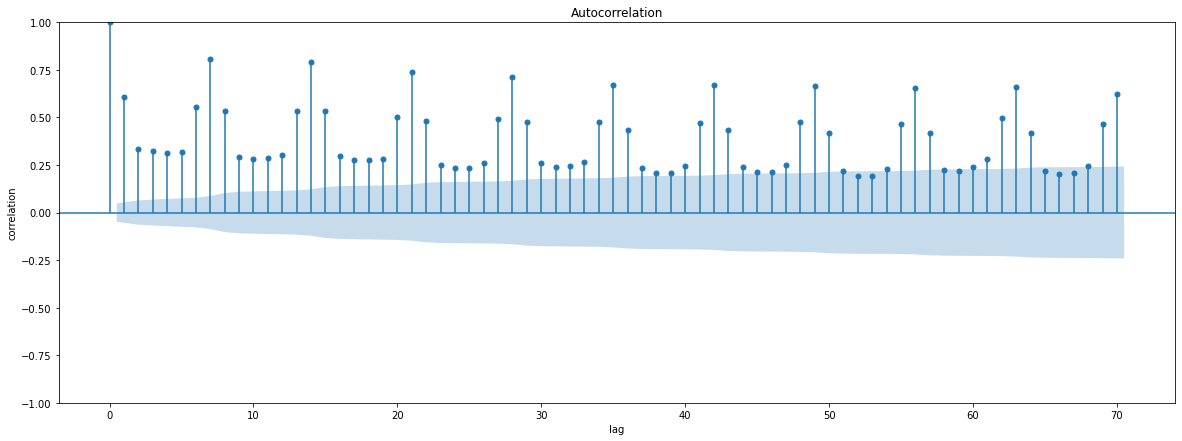

In [9]:
#attempt autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

acf_plot = plot_acf(df.y, lags = 70)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

#All lags having a value between 1.0 and 0.25 indicate that there is some monthly seasonality in this dataset

C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


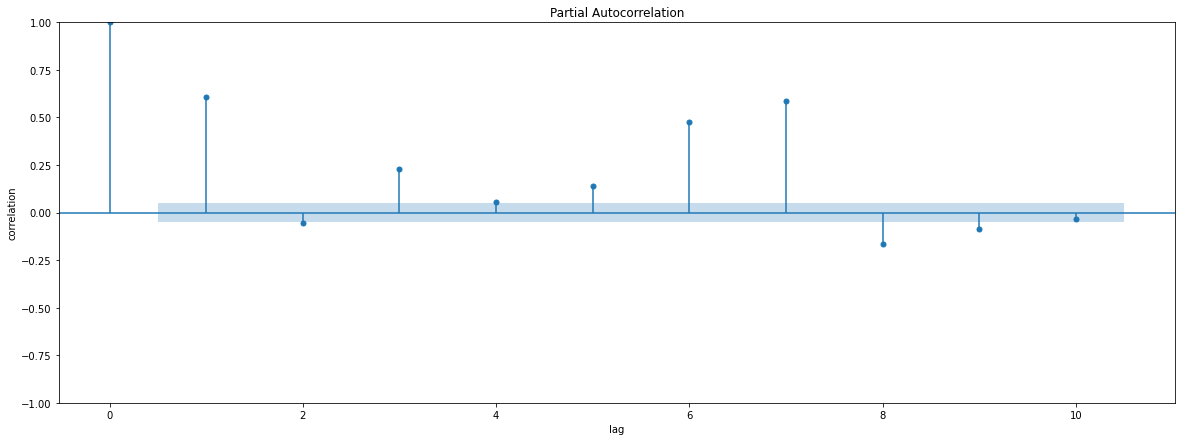

In [10]:
#attempt partial autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)

acf_plot = plot_pacf(df.y, lags = 10)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

#No statistically significant result after 9 lags

### ARIMA


In [11]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(df.y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -2.840511
p-value: 0.052716


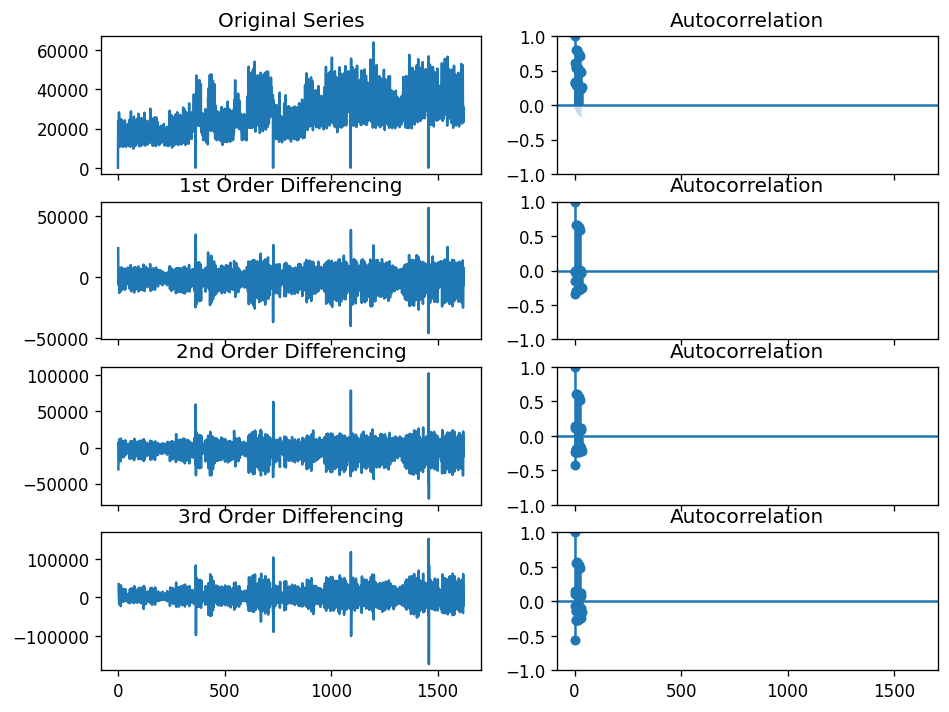

In [12]:
#What effect will differencing have?

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(df.y); axes[0, 0].set_title('Original Series')
plot_acf(df.y, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.y.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.y.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.y.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.y.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(df.y.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(df.y.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

#Approximate stationarity is reached after 3 differences - VERY GOOD

C:\Users\Owner\AppData\Roaming\Python\Python39\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


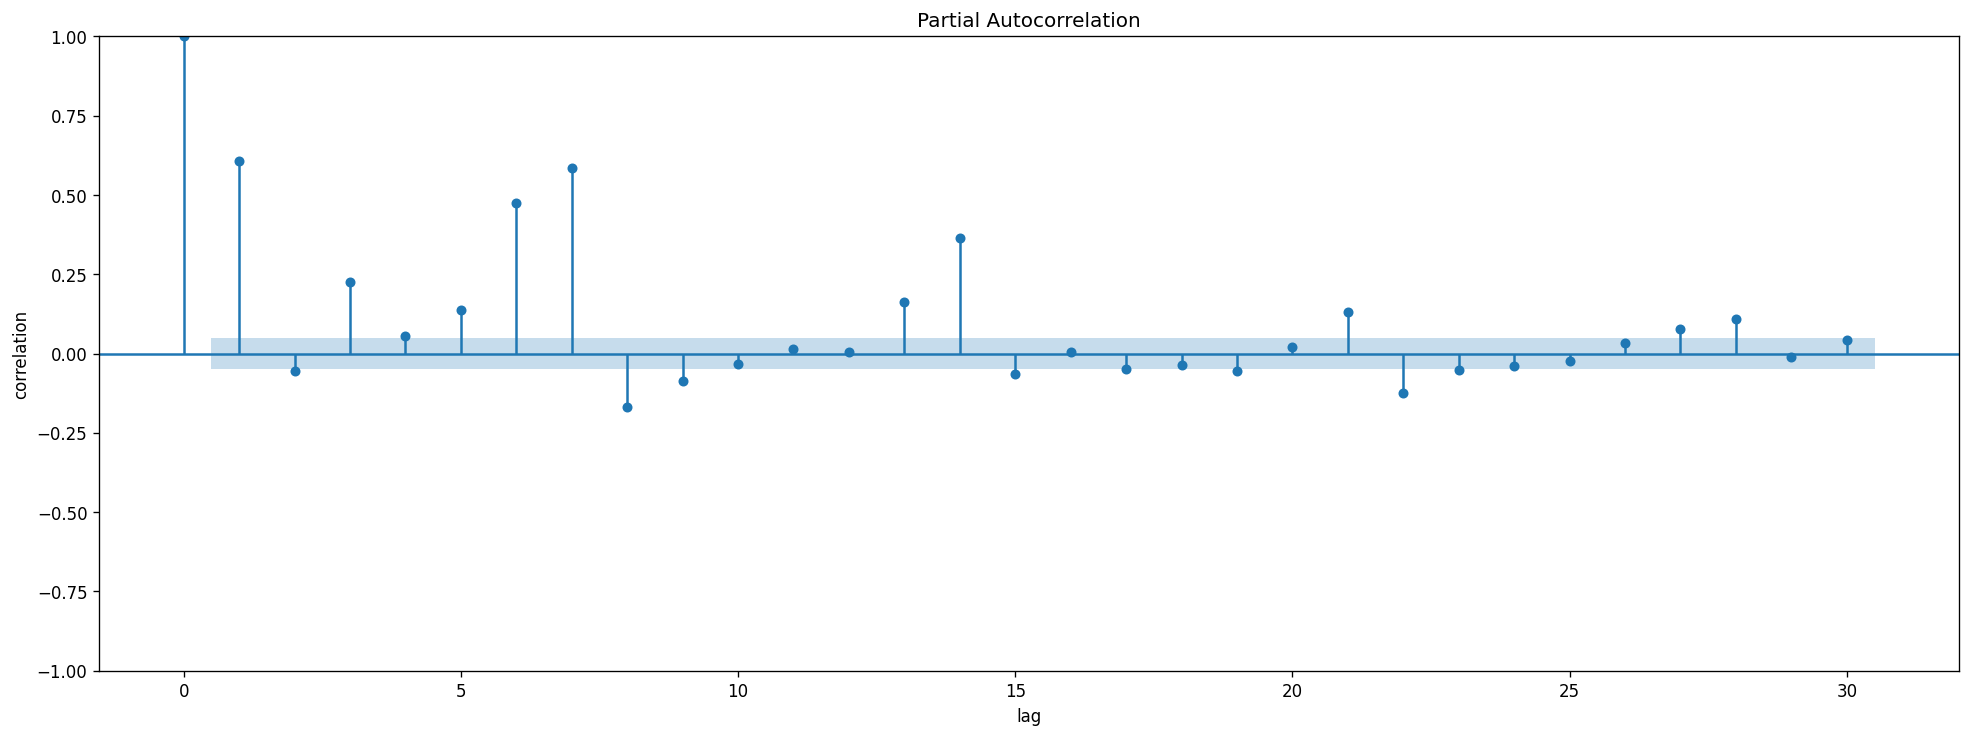

In [13]:
plt.rcParams["figure.figsize"] = (20,7)

acf_plot = plot_pacf(df.y, lags = 30) #will increasing the number of lags have an effect?
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

#The lack of statistically significant effects after the 15th lag suggests that seasonality is limited to approx. every 2 weeks

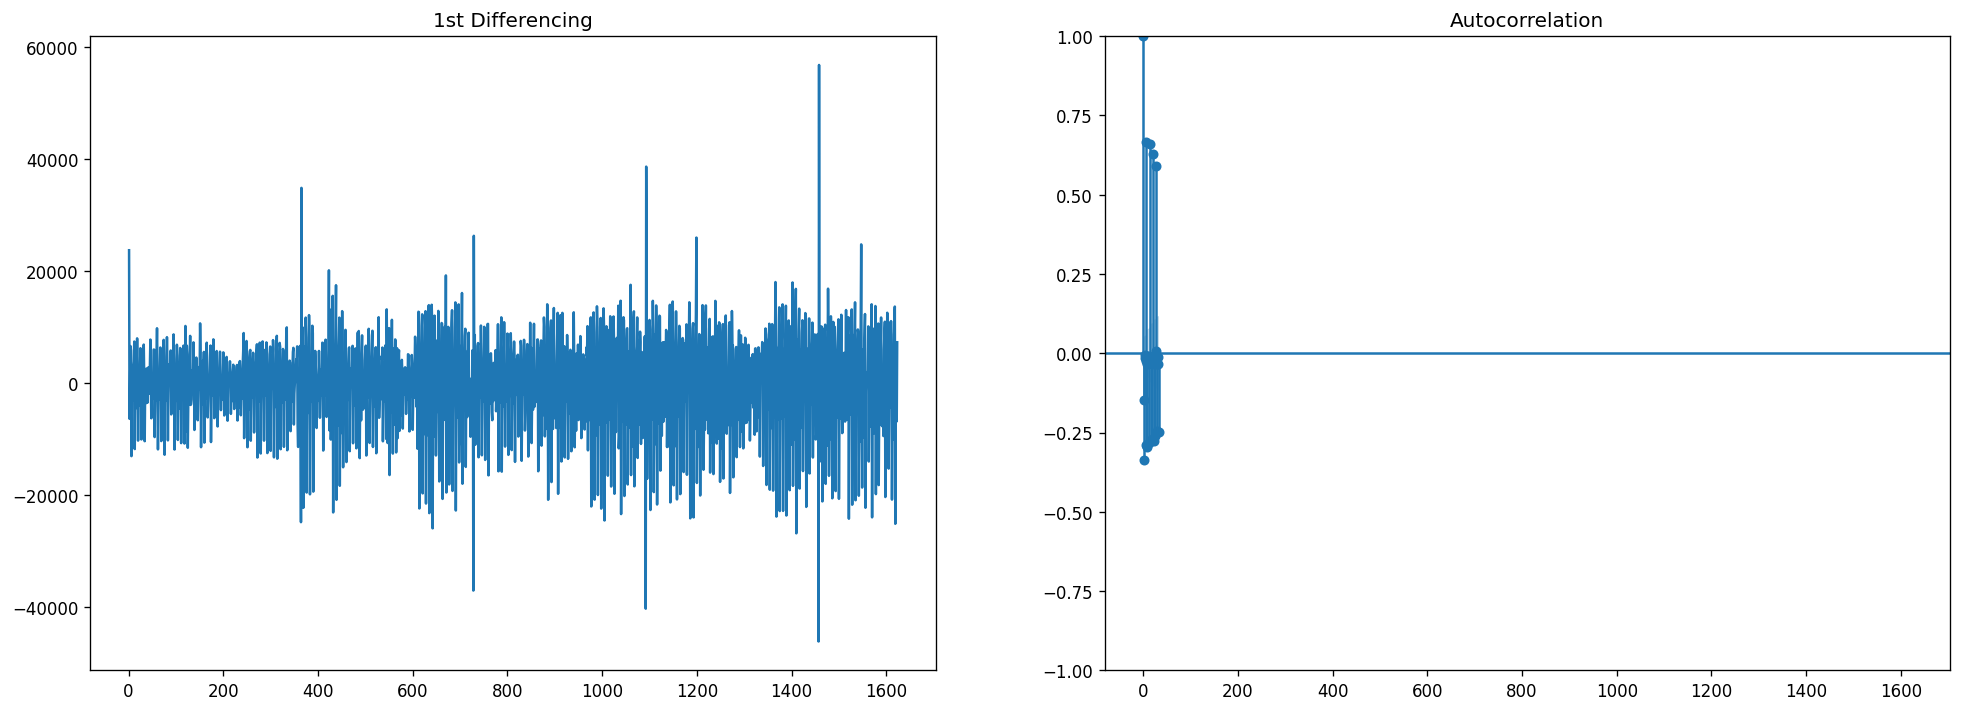

In [14]:
#next, investigate whether shifting the moving average order makes anyhting interesting happen

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.y.diff()); axes[0].set_title('1st Differencing')
axes[1].set()
plot_acf(df.y.diff().dropna(), ax=axes[1])

plt.show()

In [20]:
#INITIATE OPERATION CROSS_VALIDATE
import statsmodels.api as sm

df_ar = df.copy()

train = df_ar.y[:1200]
test = df_ar.y[1200:]

# order = (p, d, q) 
model = sm.tsa.ARIMA(train, (1, 2, 0))
model_fit = model.fit()
model_fit.summary()

ValueError: endog and exog matrices are different sizes

In [16]:
# Plot residual errors
import pandas as pd

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

NameError: name 'model_fit' is not defined

In [17]:
model_fit.plot_predict(dynamic=False)
plt.show()

NameError: name 'model_fit' is not defined

In [18]:
# Forecast
fc, se, conf = model_fit.forecast(12, alpha=0.9)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

NameError: name 'model_fit' is not defined

### PROPHET

In [19]:
from pandas import read_csv
from pandas import to_datetime
from pandas import DataFrame
from fbprophet import Prophet
from matplotlib import pyplot


# prophet requires fixed name of columns. 
# ds -> datetime
# y -> values

df_pp = df.copy()
df_pp.columns = ['ds', 'y']
df_pp['ds'] = to_datetime(df_pp['ds'])
df_pp.head()

train_pp = df_pp[:1300]
test_pp = df_pp[1300:]

ModuleNotFoundError: No module named 'fbprophet'

In [1]:
# define the model
model = Prophet()
# fit the model
model.fit(df_pp)

# get the prediction dates
future = test_pp
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

NameError: name 'Prophet' is not defined

In [2]:
#DEKOMPOSE

model.plot_components(forecast)

NameError: name 'model' is not defined

In [3]:
# plot change points in the trend.
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)



ModuleNotFoundError: No module named 'fbprophet'

An error keeps occurring after trying to install the Prophet module via pip (see attached screenshot). Tried reinstalling python, restarting, installig Visual Studio Build Tools as suggested, etc. but nothing worked! 🤬😤 Such is the nature of software 😂

### ANSWERS TO Q'S

1. The ARIMA model handles seasonality, trend, and cyclic components by constructing a function composed of lags of prior dependent variable values and lags of previously predicted forecast errors. Stationarity is established through auto-regression (AR), integration of differenced components (I), and a moving average of errors (MA). If these components are not properly processed then the remaining nonlinearities will cause the forecast to be inaccurate. We can tell if this happens by observing the autocorrelation plots for any discrepancies.

2. Unlike ARIMA, ETS explicity incorporates an exponential smoothing term to deal with growth and decay periods in the data. Predictions for the next data point are made only from the most recently observed point which are then summed to account for trend and seasonality. 

3. The difference between a 'typical' growth function and the one used in the Prophet model is that the latter (in both linear and logistic forms) is able to specify exact change points, usually determined from historical data on the assumption that the future will be more or less similar.

4. The following models can handle seasonality of non-integer length: Prophet w/ Fourier series & tbats

5. ACF differs from PACF in the sense that the former correlates the entire time series with itself without controlling for shorter lag periods, whereas the latter regresses after removing a certain number of data points, hence the name partial autocorrelation.